In [1]:
import cv2
import os
import torch
import json
import numpy as np
from tqdm.notebook import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from mmcv.transforms import Compose
from mmdet.utils import get_test_pipeline_cfg

def read_json(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return data

def read_txt(txt_path):
    with open(txt_path) as f:
        data = f.readlines()
    data = [x.strip() for x in data]
    return data

def preprocess(test_pipeline, image):
    if isinstance(image, np.ndarray):
        # Calling this method across libraries will result
        # in module unregistered error if not prefixed with mmdet.
        test_pipeline[0].type = 'mmdet.LoadImageFromNDArray'
    test_pipeline = Compose(test_pipeline)
    return test_pipeline(dict(img=image))

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_json_path, transform=None):
        self.transform = transform
        self.images_dir = images_dir
        self.annotations_json = read_json(annotations_json_path)


    def __len__(self):
        return len(self.annotations_json['images'])

    def __getitem__(self, idx):
        image_dict = self.annotations_json['images'][idx]
        image_path = os.path.join(self.images_dir, image_dict['file_name'])
        image_id = image_dict['id']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            transformed_images = self.transform(image)
        else:
            transformed_images = image

        return image_id, image_path, transformed_images


# calibrationDataloader = DataLoader(calibrationDataset, batch_size=32, shuffle=True)

In [2]:
import torch
from mmdet.apis import DetInferencer

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([640, 640]),  # Resize
])

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CONFIG_PATH = '/teamspace/studios/this_studio/mmdetection/rtmdet_tiny_8xb32-300e_coco.py'
WEIGHTS_PATH = '/teamspace/studios/this_studio/mmdetection/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'
EVAL_DATASET_SIZE = 5000
CALIBRATION_DATASET_SIZE = 1000
BATCH_SIZE = 64

ROOT_DATASET_DIR = '/teamspace/studios/this_studio/COCO'
IMAGES_DIR = os.path.join(ROOT_DATASET_DIR, 'images')
ANNOTATIONS_JSON_PATH = os.path.join(ROOT_DATASET_DIR, 'annotations/instances_val2017.json')
# ANNOTATIONS_JSON_PATH = "/home/shayaan/Desktop/aimet/my_mmdet/temp.json"

model = DetInferencer(model=CONFIG_PATH, weights=WEIGHTS_PATH, device=DEVICE)
evalDataset = CustomImageDataset(images_dir=IMAGES_DIR, annotations_json_path=ANNOTATIONS_JSON_PATH, transform=transform)
eval_data_loader = DataLoader(evalDataset, batch_size=BATCH_SIZE)
calibration_images = read_txt('/teamspace/studios/this_studio/aimet/Examples/torch/quantization/calibration_image_ids.txt')
calibration_data_loader = DataLoader(calibration_images, batch_size=BATCH_SIZE)

DEVICE

[2024-09-13 05:56:46,268] [WARNING] [real_accelerator.py:162:get_accelerator] Setting accelerator to CPU. If you have GPU or other accelerator, we were unable to detect it.
[2024-09-13 05:56:46,291] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cpu (auto detect)
Loads checkpoint by local backend from path: /teamspace/studios/this_studio/mmdetection/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

09/13 05:56:51 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


device(type='cpu')

In [3]:
from collections import OrderedDict
from copy import deepcopy

m = deepcopy(model.model)

def is_leaf(module): 
    return len(module._modules) == 0

def replace_bn(m):

    if is_leaf(m):
        return 

    for _, child in m.named_children(): 
        
        if "bn" in child._modules.keys():
            bn = child._modules.get("bn")
            bn_params = deepcopy(bn._parameters)
            bn_buffers = deepcopy(bn._buffers)
            new_bn = torch.nn.BatchNorm2d(bn.num_features, eps=bn.eps, momentum=bn.momentum, affine=bn.affine, track_running_stats=bn.track_running_stats)
            new_bn._parameters["weight"].data = bn_params["weight"].data
            new_bn._parameters["bias"].data = bn_params["bias"].data
            new_bn._buffers["running_mean"].data = bn_buffers["running_mean"].data
            new_bn._buffers["running_var"].data = bn_buffers["running_var"].data
            new_bn._buffers["num_batches_tracked"].data = bn_buffers["num_batches_tracked"].data
            child._modules["bn"] = new_bn
            
        replace_bn(child)

from aimet_torch.batch_norm_fold import fold_all_batch_norms
from aimet_torch.model_preparer import prepare_model
replace_bn(m)
aimet_m = prepare_model(deepcopy(m))
folded_pairs = fold_all_batch_norms(aimet_m, input_shapes=(1, 3, 640, 640))
len(folded_pairs)
# print(m)
# m(torch.rand(1, 3, 640, 640).to(DEVICE))[0][0].shape

2024-09-13 06:00:42,696 - root - INFO - AIMET
2024-09-13 06:00:51,401 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage1.1.blocks.0.module_add} 
2024-09-13 06:00:51,424 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage1.1.module_cat} 
2024-09-13 06:00:51,425 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage1.1.attention.module_mul} 
2024-09-13 06:00:51,426 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage2.1.blocks.0.module_add_1} 
2024-09-13 06:00:51,427 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage2.1.module_cat_1} 
2024-09-13 06:00:51,427 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage2.1.attention.module_mul_1} 
2024-09-13 06:00:51,428 - ModelPreparer - INFO - Functional         : Adding new module for node: {backbone.stage3.1.blocks.0.modu

76

In [5]:
# MODULES TO IGNORE AFTER FOLDING
modules_to_ignore = ["backbone.stage2.1.blocks.0.conv2.depthwise_conv.conv", "backbone.stage1.1.blocks.0.conv2.depthwise_conv.conv", "backbone.stage2.1.blocks.0.conv2.pointwise_conv.conv", "backbone.stage3.1.blocks.0.conv2.depthwise_conv.conv", "backbone.stage4.2.blocks.0.conv2.depthwise_conv.conv", "neck.top_down_blocks.0.blocks.0.conv2.depthwise_conv.conv", "neck.top_down_blocks.1.blocks.0.conv2.depthwise_conv.conv", "neck.bottom_up_blocks.0.blocks.0.conv2.depthwise_conv.conv", "neck.bottom_up_blocks.1.blocks.0.conv2.depthwise_conv.conv"]

len(modules_to_ignore)

9

In [4]:
from tqdm.notebook import tqdm
import torch

from mmdet.models.utils import samplelist_boxtype2tensor
from mmengine.registry import MODELS
from mmcv.transforms import Compose

test_evaluator = model.cfg.test_evaluator
test_evaluator.type = 'mmdet.evaluation.CocoMetric' 
test_evaluator.dataset_meta = model.model.dataset_meta
test_evaluator.ann_file = ANNOTATIONS_JSON_PATH
test_evaluator = Compose(test_evaluator)

collate_preprocessor = model.preprocess
predict_by_feat = model.model.bbox_head.predict_by_feat
rescale = True

preprocessor = MODELS.build(model.cfg.model.data_preprocessor)
def add_pred_to_datasample(data_samples, results_list):
    for data_sample, pred_instances in zip(data_samples, results_list):
        data_sample.pred_instances = pred_instances
    samplelist_boxtype2tensor(data_samples)
    return data_samples

loading annotations into memory...


Done (t=1.07s)
creating index...
index created!


In [5]:
def pass_calibration_data(model: torch.nn.Module, samples: int):
    data_loader = eval_data_loader
    batch_size = data_loader.batch_size
    model.eval()
    batch_ctr = 0
    with torch.no_grad():
        for image_path in tqdm(calibration_data_loader):
            image_path = [os.path.join(IMAGES_DIR, x) for x in image_path]
            pre_processed = collate_preprocessor(inputs=image_path, batch_size=batch_size)
            _, data = list(pre_processed)[0]
            data = preprocessor(data, False)
            
            preds = model(data['inputs'].to(DEVICE))  

            # batch_ctr += 1
            # if (batch_ctr * batch_size) > samples:
            #     break

In [13]:
from aimet_torch.quantsim import QuantizationSimModel
from aimet_common.defs import QuantScheme, QuantizationDataType
from aimet_torch.model_preparer import prepare_model
from aimet_torch.batch_norm_fold import fold_all_batch_norms

def exclude_modules_from_quant(sim, modules_to_ignore):
    name_to_quant_wrapper_dict = {}
    for name, module in sim.model.named_modules():
        name_to_quant_wrapper_dict[name] = module

    quant_wrappers_to_ignore = []
    for name in modules_to_ignore:
        quant_wrapper = name_to_quant_wrapper_dict[name]
        quant_wrappers_to_ignore.append(quant_wrapper)

    sim.exclude_layers_from_quantization(quant_wrappers_to_ignore)

dummy_input = torch.rand(1, 3, 640, 640).to(DEVICE)  # Shape for each ImageNet sample is (3 channels) x (224 height) x (224 width)

BASE_PATH = "/teamspace/studios/this_studio/aimet/exported_models/exported_model_int16_encodings"
m = torch.load(f"{BASE_PATH}/rtm_det.pth", map_location=DEVICE)
# m = replace_bn(model.model)
# m = prepare_model(m)
folded_pairs = fold_all_batch_norms(m, input_shapes=(1, 3, 640, 640))
print(len(folded_pairs), " Folded Batch Norms")
quant_sim = QuantizationSimModel(model=m,
                                quant_scheme=QuantScheme.post_training_tf_enhanced,
                                default_param_bw=8,
                                default_output_bw=8,
                                config_file=None,
                                dummy_input=dummy_input)

### if load encodings
# quant_sim.load_encodings(encodings="/teamspace/studios/this_studio/aimet/Examples/torch/quantization/sim_model_excluded_modules/rtm_det_torch.encodings")
# quant_sim.load_encodings(encodings="/teamspace/studios/this_studio/aimet/Examples/torch/quantization/quant_scheme_W@tf / A@tf/rtm_det_torch.encodings")
quant_sim.load_encodings(encodings=f"{BASE_PATH}/rtm_det_torch.encodings")

## else compute encodings
# quant_sim.compute_encodings(pass_calibration_data, 1000)

# modules_to_ignore = ['backbone.stage2.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_14', 'backbone.stage1.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_7', 'backbone.stage2.1.blocks.0.conv2.pointwise_conv.conv', 'backbone.stage3.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_21', 'backbone.stage4.2.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_30', 'neck.top_down_blocks.0.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_37', 'neck.top_down_blocks.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_44', 'neck.bottom_up_blocks.0.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_51', 'neck.bottom_up_blocks.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_58']
# exclude_modules_from_quant(quant_sim, modules_to_ignore)


2024-09-13 06:11:03,946 - BatchNormFolding - INFO - 0 BatchNorms' weights got converted
0  Folded Batch Norms
2024-09-13 06:11:10,005 - Quant - INFO - No config file provided, defaulting to config file at /usr/local/lib/python3.10/dist-packages/aimet_common/quantsim_config/default_config.json
2024-09-13 06:11:10,042 - Quant - INFO - Unsupported op type Squeeze
2024-09-13 06:11:10,043 - Quant - INFO - Unsupported op type Mean
2024-09-13 06:11:10,064 - Quant - INFO - Selecting DefaultOpInstanceConfigGenerator to compute the specialized config. hw_version:default


In [13]:
dict(quant_sim.model.named_modules())['backbone.stem.0.conv'].__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('_module_to_wrap',
               Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))]),
 'output_quantizers': [<aimet_torch.tensor_quantizer.StaticGridPerTensorQuantizer at 0x7f8c8d9e3190>],
 '_mode': <QcQuantizeOpMode.ACTIVE: 3>,
 'param_quantizers': {'weight': <aimet_torch.tensor_quantizer.StaticGridPerTensorQuantizer at 0x7f8c8d9e1750>,
  'bi

In [9]:
print(str(quant_sim))

-------------------------
Quantized Model Report
-------------------------
----------------------------------------------------------
Layer: backbone.stem.0.conv
  Input[0]: bw=8, encoding-present=True
    StaticGrid TensorQuantizer:
    quant-scheme:QuantScheme.post_training_tf_enhanced, round_mode=RoundingMode.ROUND_NEAREST, bitwidth=8, enabled=True
    min:-2.127063035964966, max=2.6308412551879883, delta=0.01865844801068306, offset=-114.0
  -------
  Param[weight]: bw=8, encoding-present=True
    StaticGrid TensorQuantizer:
    quant-scheme:QuantScheme.post_training_tf_enhanced, round_mode=RoundingMode.ROUND_NEAREST, bitwidth=8, enabled=True
    min:-1.6609264612197876, max=1.647950530052185, delta=0.01297598797827959, offset=-128.0
  -------
  Param[bias]: Not quantized
  -------
  Output[0]: bw=8, encoding-present=True
    StaticGrid TensorQuantizer:
    quant-scheme:QuantScheme.post_training_tf_enhanced, round_mode=RoundingMode.ROUND_NEAREST, bitwidth=8, enabled=True
    min:-8.

In [38]:
# for x in dict(quant_sim.model.named_modules())['backbone.stem.0.conv'].weight.detach().cpu().numpy().flatten():
#     print(x)

dict(quant_sim.model.named_modules())['backbone.stem.0.conv._module_to_wrap']._encoding

AttributeError: 'Conv2d' object has no attribute '_encoding'

In [12]:
dict(quant_sim.model.named_modules())['backbone.stage2.1.blocks.0.conv2.depthwise_conv.conv._module_to_wrap']

Conv2d(48, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=48)

In [89]:
np.load("weight.npy").shape

(48, 1, 5, 5)

In [7]:
# import os
# BASE_PATH = "/teamspace/studios/this_studio/aimet/exported_models/bn_folded_int8_encodings"
# os.makedirs(BASE_PATH, exist_ok=True)

# quant_sim.export(path=BASE_PATH,
#             filename_prefix="rtm_det",
#             dummy_input=dummy_input.cpu(),
#             use_embedded_encodings=False,
#             export_to_torchscript=False,)

In [13]:
# import os

# os.path.exists(BASE_PATH.replace("encodings", "embedded"))

False

In [15]:
import shutil
import os

save_embedded_dir = BASE_PATH.replace("encodings", "torchscript")
shutil.rmtree(save_embedded_dir, ignore_errors=True)
os.makedirs(save_embedded_dir, exist_ok=True)

quant_sim.export(path=save_embedded_dir,
    filename_prefix="rtm_det",
    dummy_input=dummy_input.cpu(),
    use_embedded_encodings=False,
    export_to_torchscript=True,)

2024-09-13 06:12:28,767 - Quant - WARNING - Exporting encodings to yaml will be deprecated in a future release. Ensure that your code can work with the exported files ending in ".encodings" which are saved using json format. For the time being, if yaml export is needed, set aimet_common.utils.SAVE_TO_YAML to True.


KeyError: <class 'aimet_torch.elementwise_ops.BatchNorm'>

In [11]:
module_names = dict(model.named_modules())
modules_to_ignore = ['backbone.stage2.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_14', 'backbone.stage1.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_7', 'backbone.stage2.1.blocks.0.conv2.pointwise_conv.conv', 'backbone.stage3.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_21', 'backbone.stage4.2.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_30', 'neck.top_down_blocks.0.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_37', 'neck.top_down_blocks.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_44', 'neck.bottom_up_blocks.0.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_51', 'neck.bottom_up_blocks.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_58']

modules_to_ignore

['backbone.stage2.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_14',
 'backbone.stage1.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_7',
 'backbone.stage2.1.blocks.0.conv2.pointwise_conv.conv',
 'backbone.stage3.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_21',
 'backbone.stage4.2.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_30',
 'neck.top_down_blocks.0.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_37',
 'neck.top_down_blocks.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_44',
 'neck.bottom_up_blocks.0.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_51',
 'neck.bottom_up_blocks.1.blocks.0.conv2.depthwise_conv.bn.module_batch_norm_58']

In [12]:
# def exclude_modules_from_quant(sim, modules_to_ignore):
#     name_to_quant_wrapper_dict = {}
#     for name, module in sim.model.named_modules():
#         name_to_quant_wrapper_dict[name] = module

#     quant_wrappers_to_ignore = []
#     for name in modules_to_ignore:
#         quant_wrapper = name_to_quant_wrapper_dict[name]
#         quant_wrappers_to_ignore.append(quant_wrapper)

#     sim.exclude_layers_from_quantization(quant_wrappers_to_ignore)

# exclude_modules_from_quant(quant_sim, modules_to_ignore)

In [13]:
print(str(quant_sim))

-------------------------
Quantized Model Report
-------------------------
----------------------------------------------------------
Layer: backbone.stem.0.conv
  Input[0]: bw=8, encoding-present=True
    StaticGrid TensorQuantizer:
    quant-scheme:QuantScheme.post_training_tf_enhanced, round_mode=RoundingMode.ROUND_NEAREST, bitwidth=8, enabled=True
    min:-2.127063035964966, max=2.6308412551879883, delta=0.01865844801068306, offset=-114.0
  -------
  Param[weight]: bw=8, encoding-present=True
    StaticGrid TensorQuantizer:
    quant-scheme:QuantScheme.post_training_tf_enhanced, round_mode=RoundingMode.ROUND_NEAREST, bitwidth=8, enabled=True
    min:-0.4281839430332184, max=0.42483875155448914, delta=0.0033451870549470186, offset=-128.0
  -------
  Output[0]: bw=8, encoding-present=True
    StaticGrid TensorQuantizer:
    quant-scheme:QuantScheme.post_training_tf_enhanced, round_mode=RoundingMode.ROUND_NEAREST, bitwidth=8, enabled=True
    min:-3.55580997467041, max=2.9674386978149

In [6]:
from glob import glob
from mmengine.structures import InstanceData

def eval_callback(model, save_dir="./temp"):
    data_loader = eval_data_loader
    new_preds = []
    model.eval()
    with torch.no_grad():
        for image_id, image_path, _ in tqdm(data_loader):
            pre_processed = collate_preprocessor(inputs=image_path, batch_size=BATCH_SIZE)
            _, data = list(pre_processed)[0]
            data = preprocessor(data, False)
            preds = model(data['inputs'].to(DEVICE))
            batch_img_metas = [
            data_samples.metainfo for data_samples in data['data_samples']
            ]
            preds = predict_by_feat(*preds, batch_img_metas=batch_img_metas, rescale=True)
            preds = add_pred_to_datasample(data['data_samples'], preds)
            
            for img_id, pred in zip(image_id, preds):
                pred = pred.pred_instances
                new_pred = InstanceData(metainfo={"img_id": int(img_id)})
                new_pred.bboxes = [np.array(p) for p in pred['bboxes'].cpu()]
                new_pred.labels = pred['labels'].cpu()
                new_pred.scores = pred['scores'].cpu()
                new_preds.append(new_pred)

    eval_results = test_evaluator(new_preds)
    
    os.makedirs(save_dir, exist_ok=True)
    num_file = len(glob(f"{save_dir}/eval_acc_*"))
    with open(f"{save_dir}/eval_acc_{num_file}.json", "w") as f:
        json.dump(eval_results, f, indent=4)
    bbox_map = eval_results['bbox_mAP']
    return bbox_map

In [66]:
save_dir = "/teamspace/studios/this_studio/aimet/eval_stats/rtm_ptq"
eval_callback(m)

  0%|          | 0/79 [00:00<?, ?it/s]

09/05 08:24:54 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=6.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=86.13s).
Accumulating evaluation results...
DONE (t=27.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Rec

0.411

In [67]:
eval_callback(aimet_m)

  0%|          | 0/79 [00:00<?, ?it/s]

09/05 08:34:05 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=5.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=83.52s).
Accumulating evaluation results...
DONE (t=27.74s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.455
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.605
 Average Rec

0.411

In [72]:
import torch.nn as nn

conv_module = nn.Sequential(*deepcopy(list(dict(m.named_modules())['backbone.stem.0'].children())))
dummy_input = torch.randn(1, 3, 640, 640)
conv_module.eval()
print(conv_module)

with torch.no_grad():
    out = conv_module.cuda()(dummy_input.cuda())
    # out = m(dummy_input.cuda())
    

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU(inplace=True)
)


In [73]:
import torch.nn as nn

aimet_conv_module = nn.Sequential(*deepcopy(list(dict(aimet_m.named_modules())['backbone.stem.0'].children())))
aimet_conv_module.eval()
print(aimet_conv_module)

with torch.no_grad():
    aimet_out = aimet_conv_module.cuda()(dummy_input.cuda())
    # aimet_out = aimet_m(dummy_input.cuda())

Sequential(
  (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): Identity()
  (2): CustomSiLU(
    (sigmoid): Sigmoid()
    (mul): Multiply()
  )
)


In [75]:
np.linalg.norm((out - aimet_out).cpu().numpy())

0.00029928525

In [71]:
for a, b in zip(out, aimet_out):
    for x, y in zip(a, b):
        print(np.linalg.norm((x - y).cpu().numpy()))
        

0.0044812523
0.0024741616
0.0012338732
0.031380743
0.019982383
0.004093881


In [64]:
m

RTMDet(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): CSPNeXt(
    (stem): Sequential(
      (0): ConvModule(
        (conv): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (1): ConvModule(
        (conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
      (2): ConvModule(
        (conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activate): SiLU(inplace=True)
      )
    )
    (stage1): Sequential(
      (0): ConvModule(
        (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(

In [20]:
values = [float(x) for x in """0.07158082
-0.31192178
-0.08155977
-0.2157133
-0.068148546
-0.18391258
-0.040921435
1.3859875
0.100242674
-0.15189576
0.22125724
1.4865832
5.6201324
1.5691277
0.35877356
-0.030227058
-0.18953723
0.7486278
-0.07518502
-0.17183892
-0.07151511
-0.34102532
0.2027863
-0.1890019
-0.26501745
-0.0019569108
0.022930758
0.033646703
0.013761915
0.0018288182
-0.0001669618
0.03302632
0.06934
-0.022297166
-0.0005718275
0.002012699
-0.006693656
0.13313627
0.058548745
-0.0054429164
-0.0057410654
0.008974037
0.038436264
0.07071131
-0.0046409303
0.0023961
-0.00030392883
0.021859618
0.031068612
0.010618527
-0.21251065
-0.32213113
-0.042941216
0.33074445
0.0954285
-1.0438595
-1.8203585
-0.31938693
1.8880836
0.9141494
-4.5441937
-10.998739
-0.41971666
10.993026
5.108537
-1.1518004
-1.8488079
-0.39089337
1.9006333
1.7264006
-0.28346798
-0.3547951
-0.088231795
0.4853745
0.2599276
-0.011042679
-0.040837407
-0.090405874
-0.026593719
-0.0067497767
-0.037591744
0.21707308
0.33036038
-0.06785993
-0.005565824
-0.01638439
0.28216115
0.5442682
-0.053915173
0.008317416
-0.0036753446
0.049910665
-0.015916927
-0.041738402
-0.010216599
-0.00609334
0.013297745
0.021441525
-0.013519189
0.017708188
0.027653538
0.021461513
0.011152606
-0.000516962
0.017961564
0.014674656
0.08727346
0.11941508
-0.024272976
0.0030621786
-0.0031911836
0.058520537
0.5359799
0.14343908
-0.00051026134
-0.0061084405
0.015278454
0.37677655
0.11781987
-0.0033547443
0.014006876
0.017513854
0.050620876
0.0048841042
0.010048273
-0.037113823
-0.13125433
-0.64715487
-0.055520102
-0.021531468
-0.093481146
-0.26047617
-0.16700123
-0.2640254
-0.05080642
-0.9054004
-0.037084088
3.3550653
0.1866148
-0.8613851
-0.088749
-0.18339114
0.21957734
-0.2794906
-0.1525868
-0.030498417
-0.19430241
-0.58962524
-0.07698037
-0.074491866
0.5406034
0.18643185
-0.27048656
0.43350244
0.37969038
0.102030076
0.32050714
-0.75834364
0.52721775
0.30074108
-7.3260136
-1.3641876
0.7848008
-0.5267476
-8.0759735
1.5508465
0.29351935
-0.97900593
0.84637386
1.3380281
0.51284385
0.035823625
-0.5063565
0.045894288
0.43932986
0.094156876
0.054338444
-0.05088063
-0.060494196
-0.1258857
-0.034977864
-0.13744582
-0.052970596
0.10426426
-0.23678087
0.21000816
1.1802186
5.435996
1.7603337
0.4794375
-0.071015485
0.049404662
0.13851997
-0.15354598
-0.15939339
0.022240236
-0.05010009
-0.15775771
-0.009574662
-0.11390689
-0.005433778
-0.014691174
-0.021347923
-0.01939646
0.004512118
-0.0002593135
-0.028158993
-0.5323784
-0.008834514
0.011103422
-0.049763527
0.016468065
-1.763453
-0.013626814
-0.022494415
0.017123181
-0.058888044
-0.3318565
-0.047744352
0.038573407
0.008563413
-0.011313457
0.017953606
-0.018008875
0.007998251
0.031511933
0.18469329
0.235981
-0.47131273
0.08981549
1.090943
1.5690749
0.06589508
-1.7046738
-1.0639045
4.118292
9.118906
0.24257816
-9.033632
-4.454418
1.0626076
0.7576402
0.19131295
-0.93615055
-0.9457227
-0.24983406
0.33515275
0.056329194
-0.38964376
0.07308502
0.3341843
0.58477396
0.7922092
-0.13192633
-0.21035534
0.2367996
0.09132699
2.0140524
0.4565265
0.3601178
0.61962396
1.9242338
3.3477232
-2.3027618
-0.32502803
-0.35563907
-0.49562588
-5.892141
0.75396425
-0.6523788
0.045805626
0.7161494
-1.1434233
-0.61453205
-0.39137855
0.0076090987
-0.0655917
-0.33502683
-0.14786576
-0.049653165
-0.19868407
-0.2082519
1.5876694
0.1308762
-0.14544687
0.07551426
0.39622444
6.320224
-0.032555334
0.19588615
-0.10918594
-0.21644902
0.2555669
-0.25885355
-0.15903276
0.013359691
0.052319627
-0.036787987
0.027028844
0.07739656
0.0010346149
-0.0010669924
-0.029396709
-0.0071913265
0.0006422998
-0.0026616591
-0.0071935826
-0.1076143
-0.011386
-0.0023389978
-0.03723032
-0.09491175
0.48375154
-0.11246659
-0.03332224
-0.0070254547
-0.026034279
-0.04201142
-0.028202143
-0.007814965
0.0017279304
-0.00619945
-0.025058795
-0.00882775
0.0039552823
-0.015096716
0.022745624
0.025699412
0.0040511554
0.01044219
0.014263264
0.05918104
-0.016097335
0.008052302
0.0027412272
0.021570744
-0.0074084243
0.3070582
-0.000592853
0.026049469
0.012014722
0.008378964
-0.0016920624
0.036049068
0.02000603
0.010056112
0.0034889
0.023440521
0.022676796
-0.0071403617
0.0026925136
0.07397021
-0.00045547518
0.014914885
-0.008090635
-0.009716734
0.116836995
0.25849685
-0.05221743
-0.024102824
-0.029084546
0.018502811
0.88436157
0.34706903
0.044372603
0.026122985
-0.019051379
0.06943767
0.22255096
0.04109645
0.003851969
0.023426328
-0.0069030654
-0.02595894
0.027410982
-0.07482153
-0.08508671
0.2709325
-0.034885235
-0.08237091
0.06706235
0.072646596
1.0941732
0.07147793
0.048279993
0.105481945
0.12768757
1.3551685
0.12610483
0.1315257
0.10815777
0.060632907
0.8660823
0.02577904
0.09584645
-0.12907636
-0.0070775016
0.39310983
0.03749766
-0.14646684
0.00871277
0.015297917
-0.002557713
0.011440198
7.604439e-05
0.0058430573
-0.021851698
-0.007005514
0.10559357
0.036586616
-0.025719257
0.038290802
0.5515569
0.18588497
0.017017942
-0.006792177
0.11556662
0.27979565
-0.011582143
-0.00086176925
0.02095541
0.03524108
0.009930598
0.004651779
0.0064552715
0.726697
0.6692144
-5.467399
-0.1962911
-0.23613176
-1.5390186
0.4662767
-1.670096
4.1065693
0.23812468
-4.1697493
3.3139513
2.9788985
-1.2936621
-5.956037
-1.4167054
0.25405094
1.5733498
2.0583544
0.35610956
1.2693341
-1.2570674
-4.169325
-0.6438318
0.12920886
0.006159142
-0.103280485
-0.1103964
-0.054715674
0.0038494917
-0.1285292
-0.0536425
-0.32867342
-0.029229011
0.00243582
-0.07899108
-0.6077467
-4.258759
-0.44900143
-0.043565013
-0.092118084
-0.030346978
-0.37874597
0.004262085
-0.09949004
0.026120147
-0.0031904187
-0.028554656
-0.059063017
0.057789452
-0.06794521
-0.20376742
0.13881253
-0.0602274
0.15579584
0.2134874
-0.93404603
-1.3726661
2.1919577
-0.83125883
0.937508
2.6774635
5.712798
-7.9373584
-1.6755931
0.31955004
-0.37597516
1.0278854
-1.007603
0.22741465
0.21167107
-0.16941835
0.0182208
0.114903
0.109197944
0.036639802
-0.1411516
0.09289906
-0.1599274
0.022541238
0.03145378
0.005697872
-0.6316505
-0.06475735
0.05213519
-0.12307091
-0.02280966
-3.1426194
-0.05137865
-0.14653245
-0.0359617
-0.098808736
-0.41305557
-0.12467159
0.0078072664
-0.009762628
-0.08019205
-0.03985843
-0.04240299
0.040020555
-0.0055644773
0.17150994
-0.8370375
0.2875136
-0.06946801
-0.23930162
0.18191083
-0.55710304
0.07542328
-0.20384678
-0.06814091
-0.104998164
-6.4521227
0.06460192
-0.112959675
0.11616303
-0.06818484
-4.408557
0.10121242
0.011942216
0.04368627
0.18391474
-0.9405741
0.3114628
-0.004319147
0.025668517
-0.007063076
0.08789197
0.073715664
0.05147012
-0.19685711
-0.2646128
-0.3954438
-0.17779556
-0.121805444
0.19797663
1.3490336
12.102087
1.2202983
0.031051617
-0.096880704
-0.21041355
0.092465356
-0.04055123
-0.11046498
-0.02520865
0.02994969
-0.0984934
0.036045197
-0.026088668
0.019956984
-0.1109364
-0.48571044
-0.22586611
0.034003
-0.25786582
-0.30994245
0.48873246
-0.09690431
-0.39600065
-0.40660018
-0.12123761
1.987199
0.5875634
-0.46643335
-0.08744054
-0.38125834
0.12838955
-0.32066905
-0.21882659
-0.016825626
-0.046601675
-0.32791406
-0.13015217
-0.029679796
-0.00048074112
0.02938907
-0.04827951
0.035180803
0.0009779087
-0.0002455128
-0.055555455
-0.06323632
-0.07635609
0.015357262
-0.037111424
-0.11236855
0.9786509
-0.1344288
-0.03411976
0.008808437
-0.07425132
0.04282416
-0.06578819
0.032137543
-0.006222359
0.025899248
-0.03785214
0.024346532
-0.0025037907
-0.06815441
-0.07560312
-0.2216005
-0.029760767
-0.11413132
-0.11840447
-0.094151825
-0.50169563
-0.28734154
-0.09919079
-0.26349103
-0.38575876
1.923616
0.22801171
-0.3423406
-0.010432622
-0.35821357
0.053797036
-0.24781668
-0.122153625
-0.09421995
-0.19200328
-0.1566732
-0.15669905
-0.15879212
-0.0057216296
0.024043525
0.12086017
0.03859052
-0.012629791
-0.032214776
0.0008125108
0.2013932
0.015339591
-0.011608942
0.011830313
0.15213667
0.75346696
0.05868411
-0.023515772
0.015699057
0.17523004
0.35354713
-0.037092306
-0.01670158
0.026896324
0.027770704
0.024549
0.00022351847
-0.00521829
-0.01800106
-0.020632021
-0.0017685121
0.02182139
-0.009443847
0.029011276
-0.07235934
-0.013268553
-0.046792448
-0.027962789
0.035367414
0.050688416
0.7442847
0.05460915
-0.025101753
-0.019471329
-0.06463007
-0.048064254
-0.011718687
0.053446013
-0.023880033
0.030070757
0.038844462
-0.031426635
-0.04161222
0.004188143
0.02205847
-0.013435001
0.03637015
0.014538027
-0.03569326
-0.12357299
0.12000171
0.096009105
0.010162489
0.053622674
0.24657743
0.97443116
0.17737369
-0.044586774
0.087001696
0.20459795
0.21443355
-0.04934173
-0.009338013
0.010458301
-0.0245647
-0.049745202
0.027668172
0.0071557816
-0.013190164
-0.01071442
-0.0094833365
-0.01730288
-0.012137878
-0.007131035
-0.049204275
-0.005524024
-0.03523593
-0.0026233657
-0.019267064
-0.005948143
0.2521201
-0.050890286
-0.0075409967
-0.013324883
-0.020913986
-0.05787614
-0.013606261
-0.016854174
-0.0064368155
-0.009671449
-0.0049012224
-0.012712155
-0.008143761
-0.052270234
0.0036473458
-0.38738373
0.020566817
-0.015124598
0.16776666
-0.19434139
-1.3758495
0.08094674
0.26548454
-0.024953112
-1.138001
-7.6116614
-0.88975734
-0.21572264
0.0012341518
-0.14697485
-2.2482505
-0.06997814
0.09846966
-0.07008221
-0.0131318215
-0.44803476
0.0065912646
-0.08600951
0.11600019
0.18065621
-0.025473086
0.14065155
0.06498459
0.08422312
0.12243213
-0.23420359
-0.22696331
-0.11098713
0.25894615
1.3085204
1.1795348
-3.3452594
-0.7070956
0.06396486
0.15610677
0.044195917
0.01930334
-0.06329956
0.100869104
0.14613031
-0.00044007757
-0.058104064
-0.0322581
0.03884382
-0.010137749
-0.025714371
0.007525827
0.02373164
-0.019524781
0.060113814
0.012951447
-0.0060943863
0.008399602
-0.021656414
0.040103376
-0.6841512
-0.030035878
-0.021075644
-0.0065081823
-0.004932707
-0.006953838
0.01455602
0.0072050933
0.028353198
0.00035175303
-0.03506252
0.009747278
0.018520381
0.16401659
0.056267966
-0.14429273
-0.049269807
0.18566152
-0.11220138
-0.4488256
-0.6286558
-0.48263454
-0.07534741
-0.48518848
-1.4442295
-3.8298118
-1.7704209
-0.48606408
-0.1716572
-0.4443271
-0.675667
-0.37429535
-0.13546063
0.08369036
-0.2128367
-0.30736265
-0.25345454
0.16000369
0.14790358
0.050288446
-0.22782248
0.004554554
0.12018112
0.010682093
0.02852388
0.15463343
0.059805892
0.019129096
0.02028992
0.09759128
-3.8095706
-0.17414974
-0.0036273543
0.022552714
0.083282426
-0.25342894
-0.040463395
0.03902967
0.15467517
0.032649167
-0.24301869
0.057040013
0.097889364
-0.009090006
0.07445079
-0.050145715
-0.06618185
-0.019096714
-0.017378105
-0.14089428
0.033193976
-0.12409955
0.07144168
-0.032188885
-0.015556686
1.7581859
0.09022157
-0.009945648
0.06497012
-0.044080894
-0.0006026095
-0.07264037
-0.04334057
-0.04870195
-0.05824023
0.027624873
0.06999711
-0.041299623
-0.3151118
-0.17737895
0.023953637
0.2132373
0.07624638
-0.021562751
-0.32081944
1.2719159
0.542332
0.27021125
-0.62327886
-3.9942722
2.2581496
0.3624221
-0.09525071
-0.12859356
-0.84649825
0.98629326
0.7134626
0.21171664
-0.14572845
-0.5794218
0.2909244
0.14289816
0.15635245
0.051419675
0.003974901
-5.2229414
0.0030194814
0.08766774
0.2985625
0.3727059
1.7253735
0.7894519
-0.23758216
-5.7641163
-0.014958134
8.007708
2.067181
-6.275428
-0.088830635
0.5275097
2.4760132
2.1379585
-0.39743608
-0.030197771
0.32141206
-5.2915435
-0.05313696
-0.15739162
0.007683223
0.01728042
0.04160505
0.033266354
-0.0004521187
0.001418109
-0.022453887
0.085577644
0.047176983
0.00571946
-0.0060089957
0.04487026
0.16914691
-0.010846022
-0.0013810444
-0.0013143865
0.06939927
0.06818083
0.007060654
0.0040263683
0.015078969
0.030789772
0.03279614
-0.005870364
-0.0005546327
0.96257675
0.3484697
0.28542534
1.0414388
-0.020077985
0.34195897
3.8870068
-1.7739104
-1.4288049
0.80525327
-0.4966454
1.0622007
37.65354
2.1872275
1.0546215
1.4753251
-1.0739509
2.03495
4.1241875
-1.1318159
-1.1218143
0.73243755
-1.4906616
-0.74505246
-0.7842979
-0.03170385
0.20632787
-0.042230375
-0.0360459
-0.016084332
-0.012765656
0.060327563
-0.013287969
-0.00210021
0.00482714
0.0439001
0.021224536
0.045541894
0.038078517
0.018041866
-0.005543234
0.06497588
-0.008403033
0.004285561
0.008907477
-0.047680676
0.227653
-0.040535208
-0.03888385
-0.025301429
-0.33963448
-0.8631684
-4.6409645
-0.72796106
0.010730648
-0.44447187
-2.230939
-13.55062
-2.9275608
0.020536672
-0.005820824
-0.31645855
1.7133206
-0.6075358
-0.19469397
0.4309376
2.6663494
13.124632
2.7938757
-0.006494824
0.02968814
1.1789141
3.8353543
1.4229121
0.016829256
0.0036477214
-0.0024185467
-0.24637634
-0.007015506
-0.072312325
-0.086883955
-0.06157587
0.49295938
-0.18953541
-0.1031559
0.23338608
0.9865055
5.2523065
1.5662714
0.4219194
-0.080260046
-0.10862102
-0.14071545
0.011066104
-0.17777988
-0.019607106
0.047464944
-0.033978455
-0.008893201
-0.12498692
-0.033831913
0.019112032
-0.4192852
-0.06671255
-0.087298885
-0.16056898
-0.26294804
-1.0744052
0.057560124
-0.14499506
0.18563321
0.1091083
-3.7389538
-0.20220122
0.07971598
0.06439741
0.36307114
2.334406
0.69430846
-0.072400585
0.048993245
0.021713154
0.4060449
0.2032525
0.08532889
-0.14987661
0.029483324
-0.84781843
-1.2755712
-0.20531256
-0.083794944
-0.9474041
-6.003769
-1.0961709
0.4878639
-0.08945189
1.3793434
9.898528
0.8934086
0.42564842
0.9724316
1.5262814
1.0349033
0.37730598
0.66452676
0.33283487
-0.10457175
0.59382373
-0.22876738
0.5945506
-0.0057905586
-0.005518025
-0.02740345
-0.08031902
-0.017301561
-0.0029573191
0.038892295
-0.1426024
-0.13699658
-0.008430537
-0.013903673
-0.08277317
-0.67545253
-0.18437114
-0.0008352342
0.01036527
-0.008502439
-0.390153
-0.16696306
0.009938254
0.012283234
0.011697821
-0.085218616
-0.07572536
-0.022087298
0.15289989
0.10360764
-0.32236943
0.048972275
0.23613499
0.08339509
-0.041862346
0.2718072
0.35028672
-0.14243113
-0.25494596
0.086655796
-5.8409467
0.31517112
-0.1280464
0.11443226
0.1350822
0.25232562
-0.17803714
0.041981824
0.1560223
-0.008566664
-0.2672393
0.02416713
0.16687413
-0.043285202
-0.08824509
-0.11887252
-0.08897644
-0.072374955
-0.015503032
0.076929085
0.0764407
0.024893252
-0.06244883
-0.058824413
0.0083706
0.9194087
0.06987858
-0.033532012
0.0020122007
0.023975544
0.10349312
-0.025444662
-0.029871749
-0.08034651
-0.008809976
-0.063339286
-0.053673174
-0.039586157""".split("\n")]

avg = sum(values) / len(values)

avg, max(values), min(values)

(0.019709493430666677, 37.65354, -13.55062)

In [23]:
# Convert values to int8, int16, and fp16 to observe the resolution loss

int8_values = np.clip(values, -128, 127).astype(np.int8)
int16_values = np.clip(values, -32768, 32767).astype(np.int16)
fp16_values = values.astype(np.float16)

# Compare resolution loss
print("Original Values (Sample):", values[:10])
print("int8 Converted Values (Sample):", int8_values[:10])
print("int16 Converted Values (Sample):", int16_values[:10])
print("fp16 Converted Values (Sample):", fp16_values[:10])


TypeError: 'float' object cannot be interpreted as an integer

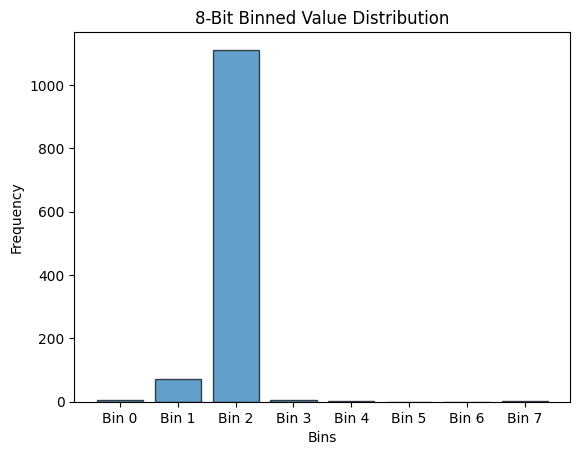

Bin 0: 7 values
Bin 1: 73 values
Bin 2: 1111 values
Bin 3: 6 values
Bin 4: 2 values
Bin 5: 0 values
Bin 6: 0 values
Bin 7: 1 values


In [27]:
# # plot a histogram of the values
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.mlab as mlab
# import matplotlib.pyplot as plt
# import math

# # the histogram of the data
# n, bins, patches = plt.hist(x=values, bins=200, density=True, facecolor='g', alpha=0.75)

# plt.xlabel('Value')
# plt.ylabel('Probability')
# plt.title('Histogram of Values')

import numpy as np
import matplotlib.pyplot as plt

# # Example: Your list of 1200 float values
# values = np.random.uniform(low=-13, high=37, size=1200)  # Replace with your actual values
values = np.array(values)
# Step 1: Normalize values to the 8-bit range [0, 255]
min_val, max_val = min(values), max(values)  # Adjust these based on your value range
normalized_values = ((values - min_val) / (max_val - min_val)) * 255

# Step 2: Define 8 bins in the 8-bit range [0, 255]
bin_edges = np.linspace(0, 255, 9)  # 8 bins from 0 to 255

# Step 3: Create histogram with 8 bins
hist, bin_edges = np.histogram(normalized_values, bins=bin_edges)

# Step 3: Create histogram with 8 bins
hist, bin_edges = np.histogram(normalized_values, bins=bin_edges)

# Step 4: Plot the histogram
plt.bar(range(8), hist, tick_label=[f'Bin {i}' for i in range(8)], edgecolor='black', alpha=0.7)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('8-Bit Binned Value Distribution')
plt.show()

# Step 5: Print total number of values falling in each bin
for i in range(len(hist)):
    print(f'Bin {i}: {hist[i]} values')


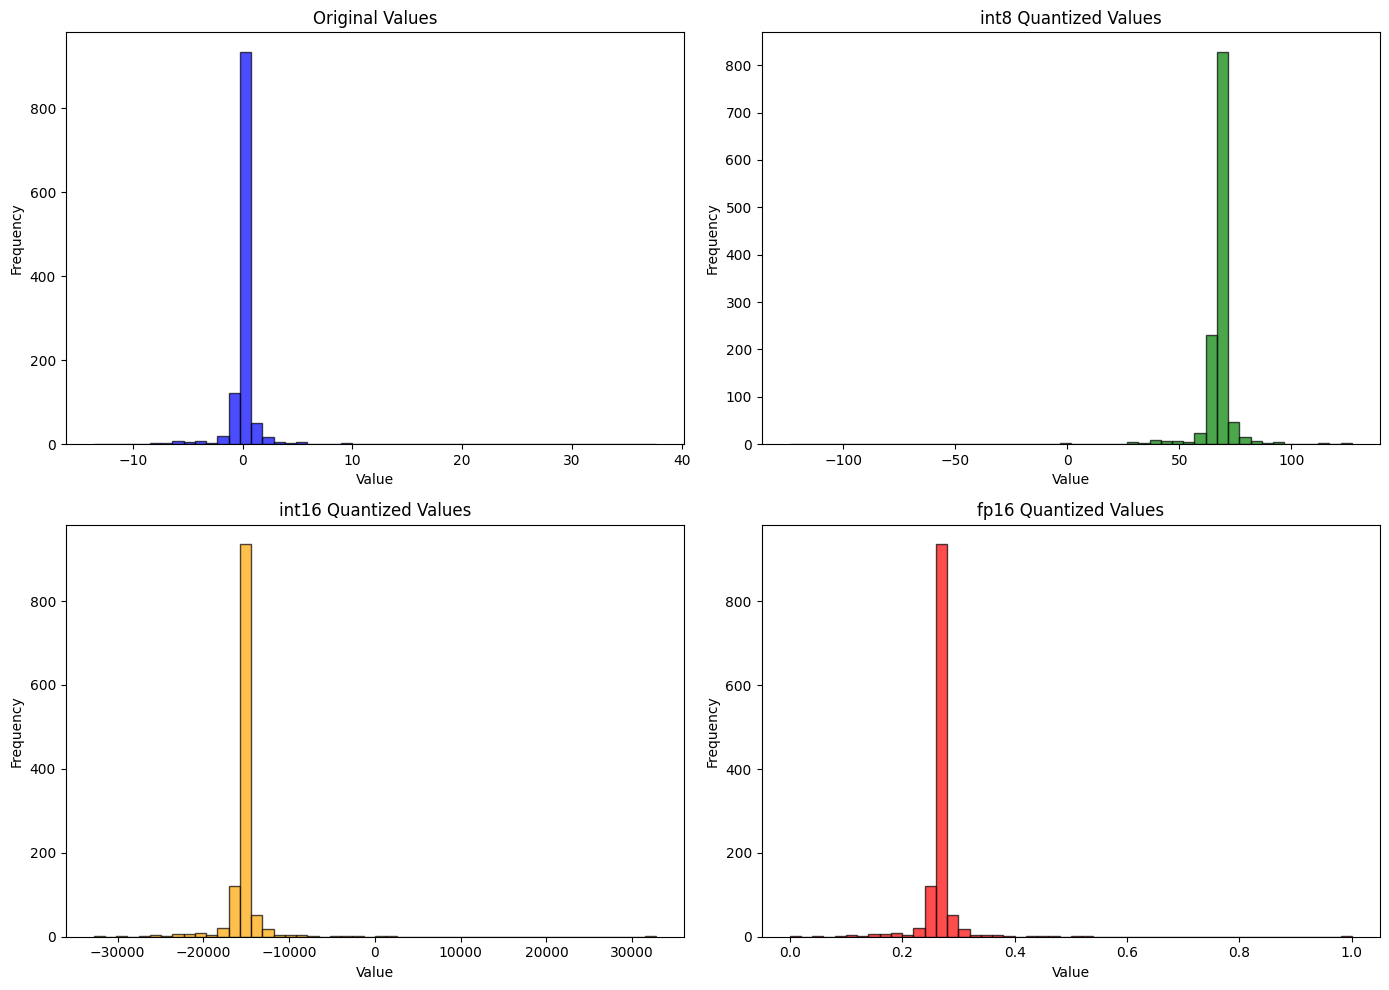

Original values (sample): [ 0.07158082 -0.31192178 -0.08155977 -0.2157133  -0.06814855 -0.18391258
 -0.04092143  1.3859875   0.10024267 -0.15189576]
int8 values (sample): [67 65 67 66 67 66 67 74 67 66]
int16 values (sample): [-15333 -15824 -15529 -15700 -15512 -15660 -15477 -13650 -15296 -15619]
fp16 values (sample): [0.266  0.2585 0.263  0.2605 0.2634 0.261  0.264  0.2917 0.2666 0.2617]


In [28]:
import numpy as np
import matplotlib.pyplot as plt
# Example: Your list of float values (Replace with your actual values)
# values = np.random.uniform(low=-13, high=37, size=1200)  # Simulated data
# Step 1: Normalize values to the range of 0-255 (for int8) and -32768 to 32767 (for int16)
min_val, max_val = min(values), max(values)
normalized_values = ((values - min_val) / (max_val - min_val))  # Normalize to [0, 1]
# Step 2: Convert to int8, int16, and fp16
int8_values = (normalized_values * 255).astype(np.int8)  # Map to [0, 255] and convert to int8
int16_values = ((normalized_values * 65535) - 32768).astype(np.int16)  # Map to int16 [-32768, 32767]
fp16_values = normalized_values.astype(np.float16)  # Convert to fp16
# Step 3: Plot the histograms for comparison
plt.figure(figsize=(14, 10))
# Original values
plt.subplot(2, 2, 1)
plt.hist(values, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Original Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
# int8 values
plt.subplot(2, 2, 2)
plt.hist(int8_values, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("int8 Quantized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
# int16 values
plt.subplot(2, 2, 3)
plt.hist(int16_values, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("int16 Quantized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
# fp16 values
plt.subplot(2, 2, 4)
plt.hist(fp16_values, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title("fp16 Quantized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# Step 4: Print sample values for comparison
print("Original values (sample):", values[:10])
print("int8 values (sample):", int8_values[:10])
print("int16 values (sample):", int16_values[:10])
print("fp16 values (sample):", fp16_values[:10])





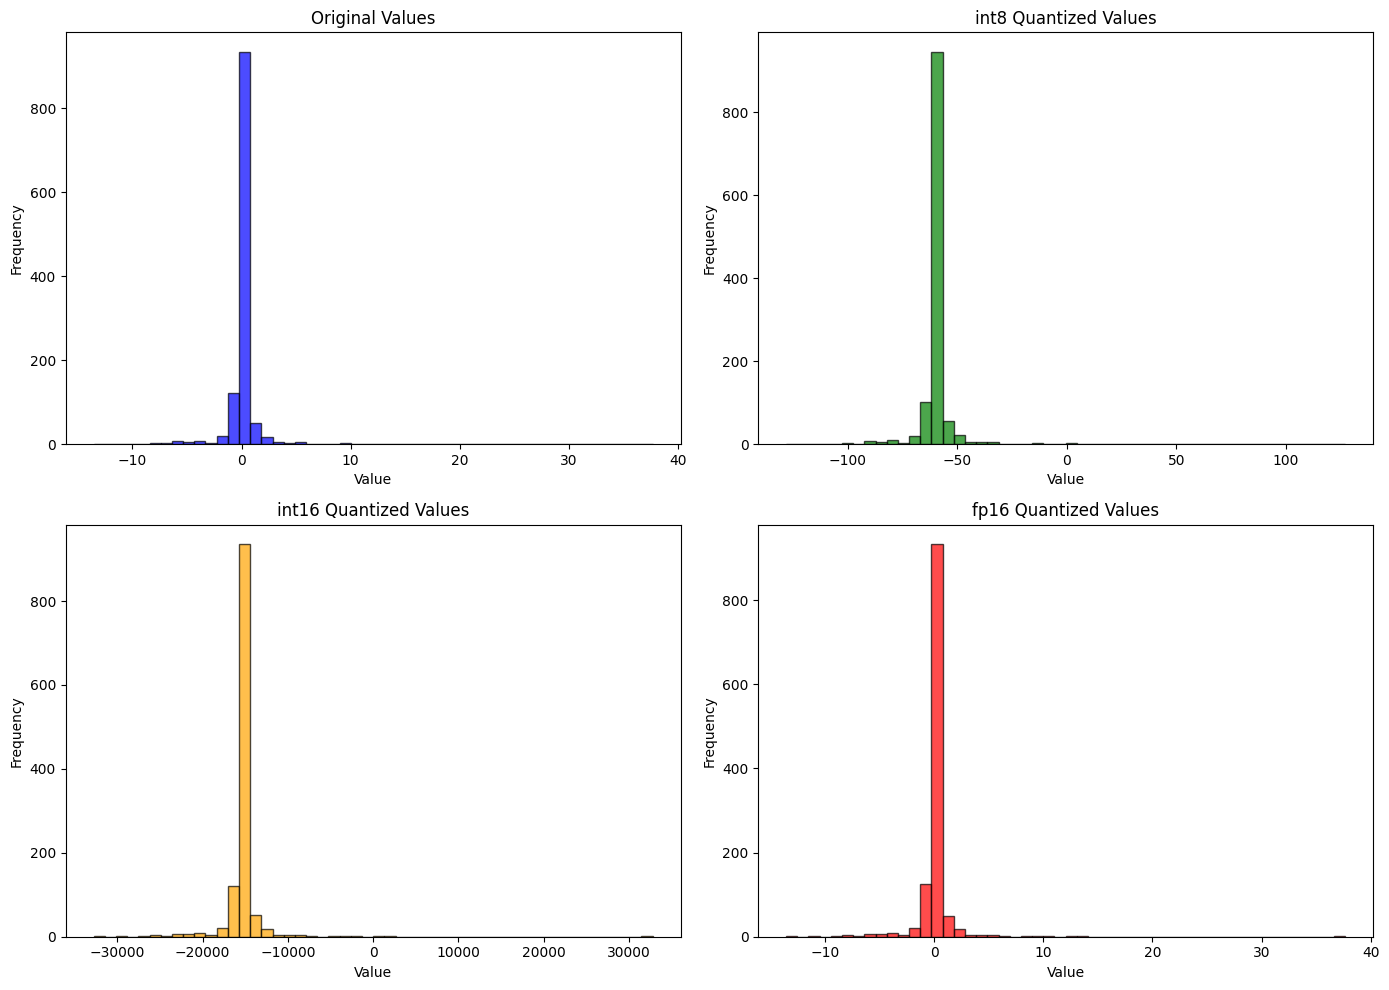

Original values (sample): [ 0.07158082 -0.31192178 -0.08155977 -0.2157133  -0.06814855 -0.18391258
 -0.04092143  1.3859875   0.10024267 -0.15189576]
int8 values (sample): [-60 -62 -60 -61 -60 -61 -60 -53 -60 -61]
int16 values (sample): [-15333 -15824 -15529 -15700 -15512 -15660 -15477 -13650 -15296 -15619]
fp16 values (sample): [ 0.0716  -0.312   -0.08154 -0.2157  -0.0682  -0.184   -0.04092  1.386
  0.1002  -0.1519 ]


In [29]:
import numpy as np
import matplotlib.pyplot as plt
# Example: Your list of float values (Replace with your actual values)
# values = np.random.uniform(low=-13, high=37, size=1200)  # Simulated data with negative values
# Step 1: Normalize values to the range for int8 [-128, 127] and int16 [-32768, 32767]
min_val, max_val = min(values), max(values)
# Normalize to [0, 1] range for consistency
normalized_values = (values - min_val) / (max_val - min_val)
# Step 2: Convert to int8, int16, and fp16
# int8 can represent values in the range [-128, 127]
int8_values = (normalized_values * 255 - 128).astype(np.int8)  # Shift to [-128, 127]
# int16 can represent values in the range [-32768, 32767]
int16_values = (normalized_values * 65535 - 32768).astype(np.int16)  # Shift to [-32768, 32767]
# fp16 doesn't need explicit normalization, just convert to fp16
fp16_values = values.astype(np.float16)
# Step 3: Plot the histograms for comparison
plt.figure(figsize=(14, 10))
# Original values
plt.subplot(2, 2, 1)
plt.hist(values, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Original Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
# int8 values
plt.subplot(2, 2, 2)
plt.hist(int8_values, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title("int8 Quantized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
# int16 values
plt.subplot(2, 2, 3)
plt.hist(int16_values, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title("int16 Quantized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
# fp16 values
plt.subplot(2, 2, 4)
plt.hist(fp16_values, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title("fp16 Quantized Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
# Step 4: Print sample values for comparison
print("Original values (sample):", values[:10])
print("int8 values (sample):", int8_values[:10])
print("int16 values (sample):", int16_values[:10])
print("fp16 values (sample):", fp16_values[:10])







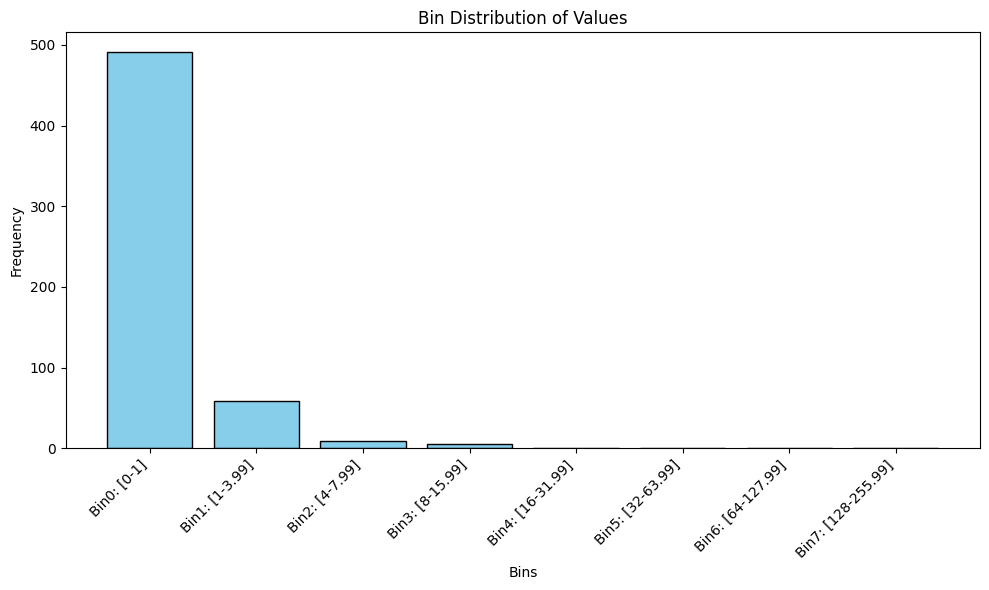

Bin0: [0-1]: 491 values
Bin1: [1-3.99]: 59 values
Bin2: [4-7.99]: 9 values
Bin3: [8-15.99]: 6 values
Bin4: [16-31.99]: 0 values
Bin5: [32-63.99]: 1 values
Bin6: [64-127.99]: 0 values
Bin7: [128-255.99]: 0 values


In [30]:
import numpy as np
import matplotlib.pyplot as plt
# Load the values from the file (you already have this loaded)
# values = np.loadtxt('/mnt/data/values.txt')  # Path to your uploaded values.txt file
# Define the bin ranges
bin_edges = [0, 1, 4, 8, 16, 32, 64, 128, 256]  # Fractions and powers of 2 based on your example
bin_labels = ['Bin0: [0-1]', 'Bin1: [1-3.99]', 'Bin2: [4-7.99]', 'Bin3: [8-15.99]',
              'Bin4: [16-31.99]', 'Bin5: [32-63.99]', 'Bin6: [64-127.99]', 'Bin7: [128-255.99]']
# Compute the histogram (the number of values in each bin)
hist, _ = np.histogram(values, bins=bin_edges)
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(hist)), hist, tick_label=bin_labels, color='skyblue', edgecolor='black')
# Add labels and title
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Bin Distribution of Values')
# Show the plot
plt.xticks(rotation=45, ha='right')  # Rotate bin labels for better readability
plt.tight_layout()
plt.show()
# Optionally print the counts in each bin for reference
for i in range(len(hist)):
    print(f'{bin_labels[i]}: {hist[i]} values')

In [79]:
import torch.nn as nn
module_index = list(dict(m.named_modules()).keys()).index('backbone.stage2.1.blocks.0.conv2.depthwise_conv.conv')
dummy_input = torch.randn(1, 3, 640, 640).cuda()

seq = nn.Sequential(*list(m.modules())[:module_index])

for name, module in seq.named_children(): 
    print(name)
    module(dummy_input)

0
1


NotImplementedError: Module [Module] is missing the required "forward" function

In [57]:
dummy_input = torch.randn(1, 48, 32, 32).cuda()
for x in dict(quant_sim.model.named_modules())['backbone.stage2.1.blocks.0.conv2.depthwise_conv.conv._module_to_wrap'](dummy_input).detach().cpu().numpy().flatten():
    print(x)

3.238312
6.936638
17.419052
17.556328
2.8048568
-1.0062182
3.0563025
6.6314096
7.26903
-3.1701803
11.347062
7.1154246
3.100235
12.449542
5.2588553
8.1507015
15.322407
13.236984
19.26949
13.517972
7.3153677
17.862642
2.2246258
-1.0454557
-1.0500255
4.858252
-0.7820819
-0.710057
0.6425387
5.9571924
2.875002
1.5826547
2.1688132
2.8160148
5.435412
0.2668295
-3.8792756
-1.551383
9.576978
12.560092
5.804619
-0.6085578
11.811463
5.1659617
2.502825
7.8439913
10.113457
7.6868463
13.782197
4.7058673
9.839979
12.153422
7.28043
17.744373
3.0991182
-2.814562
3.0585997
15.436269
7.472027
4.5022216
3.1587422
2.5442643
7.234803
11.863719
13.273462
-0.5153681
5.3200216
-0.3763532
1.5228049
-5.3064356
4.102343
9.809476
0.045535177
-0.7464315
5.6787677
-4.362028
-3.4233265
4.4688277
8.65411
4.772953
9.261849
0.41544607
9.613654
13.085898
1.9119714
5.3984566
9.67045
4.5704455
14.246084
18.352667
5.797146
9.503597
5.337094
0.96309334
2.8178377
7.0158534
6.6939025
3.1930768
10.477846
12.0398
5.647369
-0.863

5.101298
0.25322354
-0.38862145
-1.4068155
-2.8603096
-0.22749029
0.9393507
2.9992394
0.17101309
-1.4537792
-2.624072
0.00039356932
0.8338277
-1.7106705
3.8707159
-0.90193415
-2.427112
3.8462527
-0.54222554
-1.1513249
3.4623146
-0.8786293
-0.8363977
0.5139482
-1.979655
-0.8564847
2.1832068
0.19491388
0.4371864
2.7902184
3.41158
-4.1743164
-4.9724913
2.2086554
3.6193037
0.95768195
-0.340422
0.22014062
1.9754341
-1.0229609
0.6453106
3.392234
1.0887893
-1.2353846
0.5057155
-0.015607374
-0.37021643
-1.6755282
-3.6162674
0.7708901
0.5812044
0.48027682
0.5757098
0.15044314
2.5829232
1.7290972
-0.5589398
-0.7217634
1.8615195
4.1726804
2.1934094
-4.1142135
-0.7601305
4.379392
-5.3377714
0.02478008
4.0488424
-2.0188763
-3.4487135
-2.8556395
2.5138414
-0.52346516
-1.0902855
0.18193702
0.39630464
-4.001069
0.25326848
4.0301228
1.5239022
1.7507609
-2.5452774
-2.7491477
1.2427652
1.8865207
2.16011
0.6117248
-1.7554138
0.36339384
3.9526186
-2.1051054
1.7684643
0.8290635
-2.325015
0.74313194
-1.78060